Sentiment analysis remains one of the key problems that has seen extensive application of natural language processing. In this project given the tweets from customers about various tech firms who manufacture and sell mobiles, computers, laptops, etc, and I am identifying the sentiment towards such companies or products in tweets. Here sentiments are bipolar i.e Positive, labelled as 0 and Negative labelled as 1

## Loading Libraries and Data

In [205]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Import packages
import os
os.chdir(r'/Users/harsh/Desktop/NLP Project')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re # for regular expressions 
import nltk # for text manipulation 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix

In [170]:
#Reading Data file
its=pd.read_csv('Identify the sentiments.csv')

#Make copy of the dataset
itsc=its.copy()

## Preprocessing
### Data Inspection

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
5,6,1,iPhone software update fucked up my phone big ...
6,7,0,Happy for us .. #instapic #instadaily #us #son...
7,8,0,New Type C charger cable #UK http://www.ebay.c...
8,9,0,Bout to go shopping again listening to music #...
9,10,0,Photo: #fun #selfie #pool #water #sony #camera...


Shape of Dataframe: (7920, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
id                7920 non-null int64
sentiment_type    7920 non-null int64
tweet             7920 non-null object
dtypes: int64(2), object(1)
memory usage: 185.7+ KB


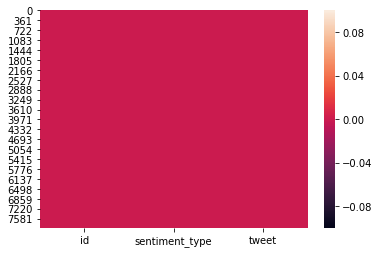

In [171]:
# checking the content of dataset
its.head(10)

#Renaming columns
its.columns=['id','sentiment_type','tweet']

#Exploring dataset Dimensions and info
print("Shape of Dataframe:",its.shape)

its.info()

#Exploring presence of null values
sns.heatmap(its.isnull()) # so, there is no null values

In [167]:
## Distribution of label types
# check the number of positive vs. negative tagged sentences
positives = its['sentiment_type'][its.sentiment_type == 0]
negatives = its['sentiment_type'][its.sentiment_type == 1]
print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(its.shape[0]))
its.sentiment_type.value_counts(normalize='True') #as positive are 75% and negative are 25% its imbalance classification problem

number of positve tagged sentences is:  5894
number of negative tagged sentences is: 2026
total length of the data is:            7920


0    0.744192
1    0.255808
Name: sentiment_type, dtype: float64

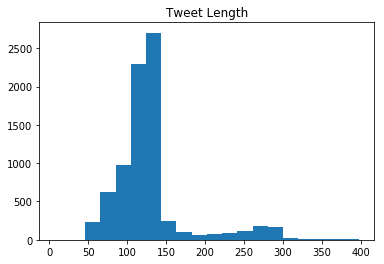

In [168]:
def tweet_length_dist(tweet_columns):
    """hecking Distribution of length of the tweets or number of characters"""
    tweet_length=tweet_columns.str.len()
    plt.hist(tweet_length, bins=20)
    plt.title("Tweet Length")
    plt.show()
    
tweet_length_dist(its.tweet)

### Data Cleaning

#### mentor's comment

In [233]:
# No need for this function. It is already a well-defined fucntion in Pandas
def drop_duplicate(tweetfile):
    """Dropping duplicates in the datasets
    Parameters
    ----------
    tweetfile : pandas dataframe
    
    Returns
    -------
    updated shape of dataframe after dropping duplicates."""
    tweetfile=tweetfile.drop_duplicates()
    return tweetfile.shape

drop_duplicate(its)


(7920, 3)

#### mentor's comment

In [ ]:
# Put all your preprocessing functions in one file, then import it and call them as below
import preprocessing_functions as prep
its.tweet=prep.lower_case(its['tweet'])

In [116]:
def lower_case(tweet_column):
    """Transforming tweets into Lower case"""
    return tweet_column.apply(lambda x: " ".join(x.lower() for x in x.split()))

    
its.tweet=lower_case(its['tweet'])
its.head()
    

,id,sentiment_type,tweet
0,1,0,#fingerprint #pregnancy test https://goo.gl/h1...
1,2,0,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...
3,4,0,i'm wired i know i'm george i was made that wa...
4,5,1,what amazing service! apple won't even talk to...


In [117]:
def remove_url(tweet_column):
    """Removing urls and web addresses"""
    return tweet_column.apply(lambda x: re.sub('http\S+','',x))

its.tweet=remove_url(its['tweet'])
its.head()

,id,sentiment_type,tweet
0,1,0,#fingerprint #pregnancy test #android #apps #...
1,2,0,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...
3,4,0,i'm wired i know i'm george i was made that wa...
4,5,1,what amazing service! apple won't even talk to...


In [118]:
def remove_handles(tweet_columns):
    """removing twitter handles (i.e. @user_name)"""
    return tweet_columns.apply(lambda x: re.sub("@[\w]*",'',x))

its.tweet=remove_handles(its['tweet'])
its.head()


,id,sentiment_type,tweet
0,1,0,#fingerprint #pregnancy test #android #apps #...
1,2,0,finally a transparant silicon case ^^ thanks t...
2,3,0,we love this! would you go? #talk #makememorie...
3,4,0,i'm wired i know i'm george i was made that wa...
4,5,1,what amazing service! apple won't even talk to...


In [125]:
appos = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","didn't" : "did not","doesn't" : "does not",
"don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","he'd" : "he would","he'll" : "he will",
"he's" : "he is","i'd" : "i would","i'd" : "i had","i'll" : "i will","i'm" : "i am","isn't" : "is not","it's" : "it is",
"it'll":"it will","i've" : "i have","let's" : "let us","mightn't" : "might not","mustn't" : "must not","shan't" : "shall not",
"she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not","that's" : "that is","there's" : "there is",
"they'd" : "they would","they'll" : "they will","they're" : "they are","they've" : "they have","we'd" : "we would",
"we're" : "we are","weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are",
"what's" : "what is","what've" : "what have","where's" : "where is","who'd" : "who would","who'll" : "who will",
"who're" : "who are","who's" : "who is","who've" : "who have","won't" : "will not","wouldn't" : "would not",
"you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have","'re": " are","wasn't": "was not",
"we'll":" will","didn't": "did not"}

def remove_apostrophes(tweet_columns):
    """Apostrophes Handling"""
    return tweet_columns.apply(lambda x: " ".join(appos[x] if x in appos else x for x in x.split()))

its.tweet=remove_apostrophes(its['tweet'])
its.head()


In [120]:
def remove_sc(tweet_columns):
    """removing special characters, numbers, punctuations, # tags"""
    return tweet_columns.apply(lambda x: re.sub("[^a-z\s]",'',x))

its.tweet=remove_sc(its['tweet'])
its.head()


,id,sentiment_type,tweet
0,1,0,fingerprint pregnancy test android apps beauti...
1,2,0,finally a transparant silicon case thanks to ...
2,3,0,we love this would you go talk makememories un...
3,4,0,i am wired i know i am george i was made that ...
4,5,1,what amazing service apple will not even talk ...


In [121]:
def remove_stopwords(tweet_columns):
    """Removal of stop words"""
    stop = stopwords.words('english')
    return tweet_columns.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

its.tweet=remove_stopwords(its['tweet'])
its.head()

,id,sentiment_type,tweet
0,1,0,fingerprint pregnancy test android apps beauti...
1,2,0,finally transparant silicon case thanks uncle ...
2,3,0,love would go talk makememories unplug relax i...
3,4,0,wired know george made way iphone cute daventr...
4,5,1,amazing service apple even talk question unles...


In [122]:
def remove_shortwords(tweet_columns):
    """Removing words having word length of 2 or less"""
    return tweet_columns.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

its.tweet=remove_shortwords(its['tweet'])
its.head()

,id,sentiment_type,tweet
0,1,0,fingerprint pregnancy test android apps beauti...
1,2,0,finally transparant silicon case thanks uncle ...
2,3,0,love would talk makememories unplug relax ipho...
3,4,0,wired know george made way iphone cute daventr...
4,5,1,amazing service apple even talk question unles...


In [123]:
def tokenization(tweet_columns):
    """Tokenization of tidy tweets"""
    return tweet_columns.apply(lambda x: word_tokenize(x))

its.tweet=tokenization(its['tweet'])
its.head()

,id,sentiment_type,tweet
0,1,0,"[fingerprint, pregnancy, test, android, apps, ..."
1,2,0,"[finally, transparant, silicon, case, thanks, ..."
2,3,0,"[love, would, talk, makememories, unplug, rela..."
3,4,0,"[wired, know, george, made, way, iphone, cute,..."
4,5,1,"[amazing, service, apple, even, talk, question..."


In [124]:
def lemmatization(tweet_columns):
    """Lemmatization of tweet tokens"""
    tweet_columns=tweet_columns.apply(lambda x:[WordNetLemmatizer().lemmatize(i,'v') for i in x])
    # Stitching of tokens back together
    for i in range(len(tweet_columns)):
        tweet_columns[i] = ' '.join(tweet_columns[i])
    return tweet_columns

its.tweet=lemmatization(its['tweet'])
its.head()

,id,sentiment_type,tweet
0,1,0,fingerprint pregnancy test android apps beauti...
1,2,0,finally transparant silicon case thank uncle y...
2,3,0,love would talk makememories unplug relax ipho...
3,4,0,wire know george make way iphone cute daventry...
4,5,1,amaze service apple even talk question unless ...


In [175]:
# Combining all function in one as preprocessing function
def Preprocessing(tweet_columns):
    # Transforming tweets into Lower case
    tweet_columns=tweet_columns.apply(lambda x: " ".join(x.lower() for x in x.split()))
    #Removing urls and web addresses
    tweet_columns=tweet_columns.apply(lambda x: re.sub('http\S+','',x))
    # removing twitter handles (i.e. @user_name)
    tweet_columns=tweet_columns.apply(lambda x: re.sub("@[\w]*",'',x))
    # Apostrophes Handling
    tweet_columns=tweet_columns.apply(lambda x: " ".join(appos[x] if x in appos else x for x in x.split()))
    # removing special characters, numbers, punctuations, # tag
    tweet_columns=tweet_columns.apply(lambda x: re.sub("[^a-z\s]",'',x))
    # Removal of stop words
    stop = stopwords.words('english')
    tweet_columns=tweet_columns.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    # Removing words having word length of 2 or less.
    tweet_columns=tweet_columns.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # Tokenization of tidy tweets
    tweet_columns=tweet_columns.apply(lambda x: word_tokenize(x))
    # Lemmatization of tidy tweet tokens
    tweet_columns=tweet_columns.apply(lambda x:[WordNetLemmatizer().lemmatize(i,'v') for i in x])
    # Stitching of tokens back together
    for i in range(len(tweet_columns)):
        tweet_columns[i] = ' '.join(tweet_columns[i])
    return tweet_columns
start_time = time.time()
print("Execution time: " + str((time.time() - start_time)) + 'seconds')

its['tweet']=preprocessing(its['tweet'])
its.head()

Execution time: 3.600120544433594e-05seconds


,id,sentiment_type,tweet
0,1,0,fingerprint pregnancy test android apps beauti...
1,2,0,finally transparant silicon case thank uncle y...
2,3,0,love would talk makememories unplug relax ipho...
3,4,0,wire know george make way iphone cute daventry...
4,5,1,amaze service apple even talk question unless ...


In [235]:
class preprocessing:
    def drop_duplicate(tweetfile):
        """Drop duplicates in the datasets

        Parameters
        ----------
        tweetfile : pandas dataframe

        Returns
        -------
        updated shape of dataframe after dropping duplicates."""
        tweetfile=tweetfile.drop_duplicates()
        return tweetfile.shape
    
    def lower_case(tweet_column):
        """Transforming tweets into Lower case"""
        return tweet_column.apply(lambda x: " ".join(x.lower() for x in x.split()))

    def remove_url(tweet_column):
        """Removing urls and web addresses"""
        return tweet_column.apply(lambda x: re.sub('http\S+','',x))

    def remove_handles(tweet_columns):
        """removing twitter handles (i.e. @user_name)"""
        return tweet_columns.apply(lambda x: re.sub("@[\w]*",'',x))


    appos = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","didn't" : "did not","doesn't" : "does not",
    "don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","he'd" : "he would","he'll" : "he will",
    "he's" : "he is","i'd" : "i would","i'd" : "i had","i'll" : "i will","i'm" : "i am","isn't" : "is not","it's" : "it is",
    "it'll":"it will","i've" : "i have","let's" : "let us","mightn't" : "might not","mustn't" : "must not","shan't" : "shall not",
    "she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not","that's" : "that is","there's" : "there is",
    "they'd" : "they would","they'll" : "they will","they're" : "they are","they've" : "they have","we'd" : "we would",
    "we're" : "we are","weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are",
    "what's" : "what is","what've" : "what have","where's" : "where is","who'd" : "who would","who'll" : "who will",
    "who're" : "who are","who's" : "who is","who've" : "who have","won't" : "will not","wouldn't" : "would not",
    "you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have","'re": " are","wasn't": "was not",
    "we'll":" will","didn't": "did not"}

    def remove_apostrophes(tweet_columns):
        """Apostrophes Handling"""
        return tweet_columns.apply(lambda x: " ".join(appos[x] if x in appos else x for x in x.split()))
    
    def remove_sc(tweet_columns):
        """removing special characters, numbers, punctuations, # tags"""
        return tweet_columns.apply(lambda x: re.sub("[^a-z\s]",'',x))

    def remove_stopwords(tweet_columns):
        """Removal of stop words"""
        stop = stopwords.words('english')
        return tweet_columns.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    def remove_shortwords(tweet_columns):
        """Removing words having word length of 2 or less"""
        return tweet_columns.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    
    def tokenization(tweet_columns):
        """Tokenization of tidy tweets"""
        return tweet_columns.apply(lambda x: word_tokenize(x))
    
    def lemmatization(tweet_columns):
        """Lemmatization of tweet tokens"""
        tweet_columns=tweet_columns.apply(lambda x:[WordNetLemmatizer().lemmatize(i,'v') for i in x])
        # Stitching of tokens back together
        for i in range(len(tweet_columns)):
            tweet_columns[i] = ' '.join(tweet_columns[i])
        return tweet_columns



## Story generation and visualization from tweets.

In [230]:
class Visualization:
    def most_common_visual(tweet_columns):
        """Most common words in all tweets"""
        words = ' '.join([t for t in tweet_columns])
        wordcloud = WordCloud(width=800, height=500, random_state=21,max_words=100, background_color="white").generate(words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Most common words in all tweets",fontdict={'fontsize':19,'fontweight':'bold'})
        plt.axis('off')
        plt.show()
    
    def pos_visual(tweet_columns,label_columns):
        """Visualization of most common words in positive tweets"""
        positive_words =' '.join([t for t in tweet_columns [label_columns == 0]])
        wordcloud = WordCloud(width=800, height=500, random_state=21,max_words=100,max_font_size=110).generate(positive_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Most common words in positive tweets",fontdict={'fontsize':19,'fontweight':'bold'})
        plt.axis('off')
        plt.show()
    
    def neg_visual(tweet_columns,label_columns):
        """Visualization of most common words in negative tweets"""
        negative_words =' '.join([t for t in tweet_columns[label_columns == 1]])
        wordcloud = WordCloud(width=800, height=500, random_state=21,max_words=100,max_font_size=110).generate(negative_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Most common words in negative tweets",fontdict={'fontsize':19,'fontweight':'bold'})
        plt.axis('off')
        plt.show()
        
    

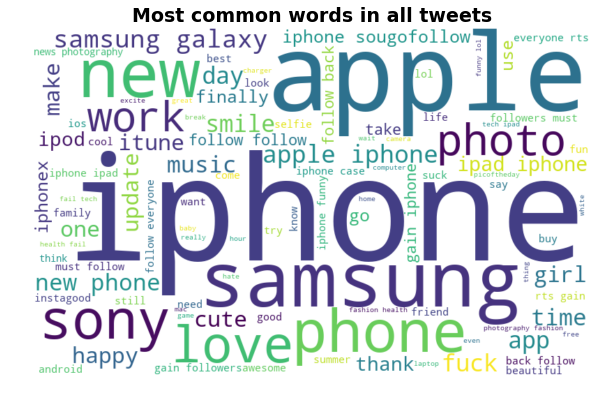

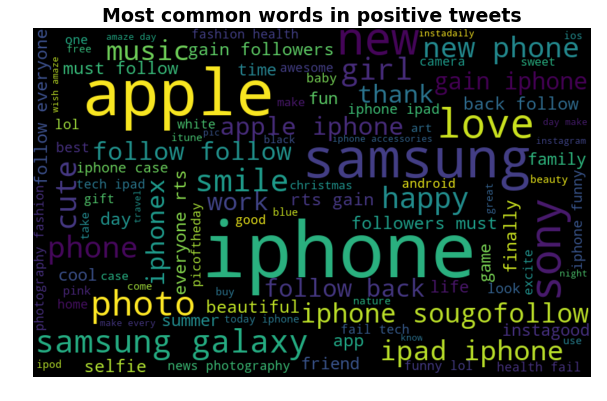

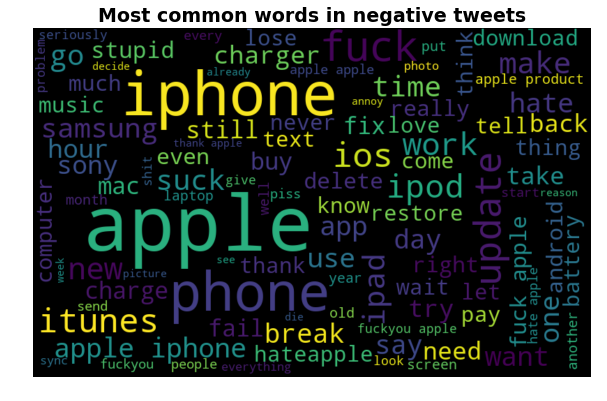

In [231]:
Visualization.most_common_visual(its.tweet)
Visualization.pos_visual(its.tweet,its.sentiment_type)
Visualization.neg_visual(its.tweet,its.sentiment_type)

Most common word is iphone followed by apple and samsung, shows among all the tech firms tweets are more incline towards iphone and apple foolwed by samsung and sony.

## Feature Extraction from cleaned Tweets


Before feature extraction lets split the data into train and test and then we will do the feature extraction and then we will train the data on model

In [214]:
def traintest_split(X,y):
    """Split into training and test (hold-out) set"""
    # 80% of the input for training and 20% for training
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.2,random_state=42,shuffle= True,stratify=y)
    print (Xtrain.shape, ytrain.shape)
    print (Xtest.shape, ytest.shape)
    return

traintest_split(its['tweet'],its['sentiment_type'])

(6336,) (6336,)
(1584,) (1584,)


### One-hot encoding Feature

In [211]:
def ohe_vectorization(X_train,X_test):
    """Vectorization (one-hot encoding)"""
    cvohe = CountVectorizer(binary=True)
    cvohe.fit(X_train)
    Xohe_train = cvohe.transform(X_train)
    Xohe_test = cvohe.transform(X_test)
    return Xohe_train,Xohe_test

ohe_vectorization(Xtrain,Xtest)

(<6336x12601 sparse matrix of type '<class 'numpy.int64'>'
 	with 65251 stored elements in Compressed Sparse Row format>,
 <1584x12601 sparse matrix of type '<class 'numpy.int64'>'
 	with 14088 stored elements in Compressed Sparse Row format>)

## Model building
We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF. First, we try a basic Logistic Regression:

- Split the data into a training and test (hold-out) set
- Train on the training set, and test for accuracy on the testing set

### a) One-hot encoding feature
### Logistic Regression
Modelling without tuning

In [240]:
def LRmodelling(X_train_vec,y_train,X_test_vec):
    """Applying Logistic Regression model"""
    #Instantiate a logistic classifier
    lr = LogisticRegression(random_state=42,class_weight='balanced')
    lr.fit(X_train_vec, y_train)
    y_predict_ohe=lr.predict(X_test_vec)
    print('The accuracy of model is: \n',accuracy_score(ytest,y_predict_ohe))
    print('The precision of model is: \n',precision_score(ytest,y_predict_ohe,pos_label=0))
    print('The recall or sensitivity of model is: \n',recall_score(ytest,y_predict_ohe,pos_label=0))
    f1score=f1_score(ytest,y_predict_ohe,pos_label=0) # calculating f1 score for positive label
    print('The f1 score of model is %.2f' %(f1score))
    print('The confusion matrix of model is: \n',confusion_matrix(ytest,y_predict_ohe))
    print('The classification report of the model is: \n',classification_report(ytest,y_predict_ohe))
    return

LRmodelling(Xohe_train,ytrain,Xohe_test)

The accuracy of model is: 
 0.8914141414141414
The precision of model is: 
 0.9412795793163892
The recall or sensitivity of model is: 
 0.910941475826972
The f1 score of model is 0.93
The confusion matrix of model is: 
 [[1074  105]
 [  67  338]]
The classification report of the model is: 
              precision    recall  f1-score   support

          0       0.94      0.91      0.93      1179
          1       0.76      0.83      0.80       405

avg / total       0.90      0.89      0.89      1584



Modelling with tuning
- cross validation for validating the stability of our machine learning model

In [182]:
# Build the k-fold cross-validator(5-fold cross-validation) and defining metrices
stratkfold = StratifiedKFold(n_splits=5, random_state=42)
scoring = ['accuracy', 'precision','recall','f1']
#calculating score for the model after CV
result = cross_validate(lr, Xohe_train, ytrain, cv=stratkfold, scoring=scoring,return_train_score=False)
print('The accuracy after CV is: \n',result['test_accuracy'].mean())
print('The precision after CV is: \n',result['test_precision'].mean())
print('The recall after CV is: \n',result['test_recall'].mean())
print('The f1 score after CV is: \n',result['test_f1'].mean())

The accuracy after CV is: 
 0.8844703826072667
The precision after CV is: 
 0.7381403289336268
The recall after CV is: 
 0.8507141500474834
The f1 score after CV is: 
 0.7902472294373464


- Hyperparameter tuning with randomized search

In [184]:
# modelling with random search (for hyperparameter tuning)
#Defining the grid values of the hyperparameters
dual=[True,False]
max_iter=[100,110,120,130,140,150]
C = [0.5,1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)
# Running Randomized search on parameters
scoring = {'accuracy':make_scorer(accuracy_score), 'precision':make_scorer(precision_score),'Recall':make_scorer(recall_score),'F1 score':make_scorer(f1_score)}
lrht = LogisticRegression(penalty='l2',class_weight='balanced')
lrrs = RandomizedSearchCV(estimator=lrht, param_distributions=param_grid, cv = 5, n_iter=20, n_jobs=-1,random_state=42,scoring=scoring,refit='accuracy')
lrrs.fit(Xohe_train, ytrain)
print('Best Score: {}%'.format(lrrs.best_score_))
print('Best Parameters: {}'.format(lrrs.best_params_))
start_time = time.time()
print("Execution time: " + str((time.time() - start_time)) + 'seconds')


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'dual': [True, False], 'max_iter': [100, 110, 120, 130, 140, 150], 'C': [0.5, 1.0, 1.5, 2.0, 2.5]},
          pre_dispatch='2*n_jobs', random_state=42, refit='accuracy',
          return_train_score='warn',
          scoring={'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'Recall': make_scorer(recall_score), 'F1 score': make_scorer(f1_score)},
          verbose=0)

Best Score: 0.88510101010101%
Best Parameters: {'max_iter': 130, 'dual': False, 'C': 1.5}
Execution time: 5.221366882324219e-05seconds


In [27]:
#LR with best parameters after hyperparameter tuning
lrbst=LogisticRegression(C=1.5,dual=False,max_iter=130,class_weight='balanced')
lrbst.fit(Xohe_train, ytrain)
y_predictbst_ohe=lrbst.predict(Xohe_test)
# Model evaluation
## Compute and print the confusion matrix and classification report
print('The accuracy of model is: \n',accuracy_score(ytest,y_predictbst_ohe))
print('The precision of model is: \n',precision_score(ytest,y_predictbst_ohe,pos_label=0))
print('The recall or sensitivity of model is: \n',recall_score(ytest,y_predictbst_ohe,pos_label=0))
f1score=f1_score(ytest,y_predictbst_ohe,pos_label=0) # calculating f1 score for positive label
print('The f1 score of model is %.2f' %(f1score))
print('The confusion matrix of model is: \n',confusion_matrix(ytest,y_predictbst_ohe))
print('The classification report of the model is: \n',classification_report(ytest,y_predictbst_ohe))

LogisticRegression(C=1.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=130,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

The accuracy of model is: 
 0.8907828282828283
The precision of model is: 
 0.9381533101045296
The recall or sensitivity of model is: 
 0.9134860050890585
The f1 score of model is 0.93
The confusion matrix of model is: 
 [[1077  102]
 [  71  334]]
The classification report of the model is: 
              precision    recall  f1-score   support

          0       0.94      0.91      0.93      1179
          1       0.77      0.82      0.79       405

avg / total       0.89      0.89      0.89      1584

